# Clustering Geolocation Data Intelligently in Python
We have taxi rank (taxi stand) locations for the city of Johannesburg, South Africa. We want to define key clusters of these taxis ranks where we can build service stations for all taxis operating in that region.

## Prerequisites
- Basic Matplotlib skills for plotting 2-D data clearly.
- Basic understanding of Pandas and how to use it for data manipulation.
- The basic concepts behind clustering algorithms. We will be working with Kmeans, DBSCAN and HDBSCAN. 

## Project Outline

[**Task 1**](#task1): Exploratory Data Analysis

[**Task 2**](#task2): Visualizing Geographical Data

[**Task 3**](#task3): Clustering Strength / Performance Metric

[**Task 4**](#task4): K-Means Clustering

[**Task 5**](#task5): DBSCAN

[**Task 6**](#task6): HDBSCAN

[**Task 7**](#task7): Addressing Outliers


In [7]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg' #Decide the default image format for inline figures: SVG or PNG
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from tqdm import tqdm # makes your loops show a progess bar

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from collections import defaultdict

import hdbscan # HDBSCAN is not available in sklearn. 
import folium # Used for plotting geo-spatial data on a map.

# Pre-defining different colors and a long list of it so it can be assigned to different clusters later.
cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

<a id='task1'></a>
# Task 1: Exploratory Data Analysis

In [8]:
# Reading the Data
df = pd.read_csv('taxi_data.csv')
df.tail()

LON       LAT                   NAME
833  27.82999 -26.24445  Zola Clinic Taxi Rank
834  27.83991 -26.24235         Zola Taxi Rank
835  27.86166 -26.23624        Zondi Taxi Rank
836  28.39097 -26.30931     kwaThema Taxi Rank
837       NaN       NaN                    NaN

In [9]:
df.shape

(838, 3)

In [10]:
# Checking for duplicated Values
df.duplicated(subset = ['LON', 'LAT']).values.any()

True

In [11]:
# Checking for NAN / Missing values
df.isna().values.any()

True

In [12]:
# Dropping NaNs and duplicated values

print(f'Before dropping NaNs and dupes\t:\tdf.shape = {df.shape}')
df.dropna(inplace = True)
print(f'After dropping NaNs\t:\tdf.shape = {df.shape}')
df.drop_duplicates(subset = ['LON','LAT'],keep = 'first',inplace = True)
print(f'After dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

Before dropping NaNs and dupes	:	df.shape = (838, 3)
After dropping NaNs	:	df.shape = (837, 3)
After dropping NaNs and dupes	:	df.shape = (823, 3)


In [13]:
# Feature Array 
X = np.array(df[['LON','LAT']],dtype = 'float64') #float64 so that we dont lose on information.
X

array([[ 28.17858, -25.73882],
       [ 28.1766 , -25.73795],
       [ 27.83239, -26.53722],
       ...,
       [ 27.83991, -26.24235],
       [ 27.86166, -26.23624],
       [ 28.39097, -26.30931]])

Text(0, 0.5, 'LAT')

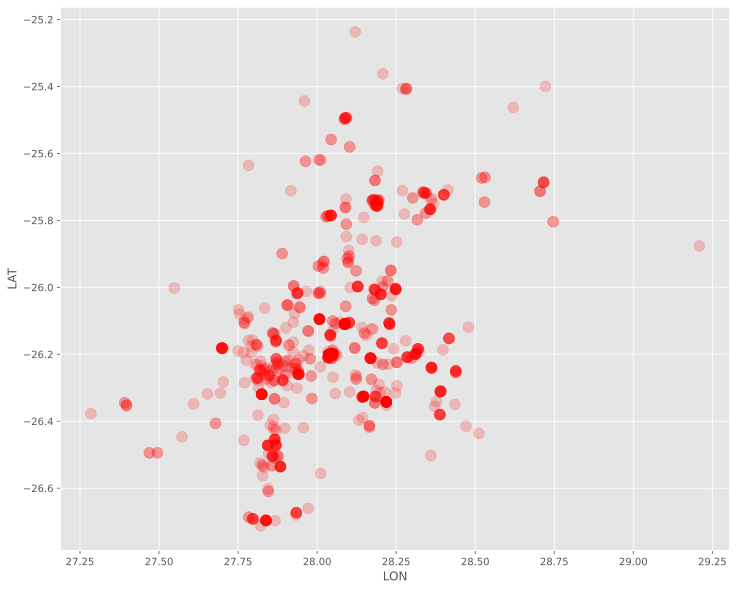

In [14]:
# Visualising taxi ranks in a 2-D plot
plt.figure(figsize=(12,10))
plt.scatter(X[:,0],X[:,1],alpha = 0.2, s=120,color = 'r')
plt.xlabel('LON')
plt.ylabel('LAT')

<a id='task2'></a>
# Task 2: Visualizing Geographical Data


In [17]:
import re
# Creating a map object
m = folium.Map(location = [df['LAT'].mean(), df['LON'].mean()], zoom_start=9, tiles = 'Stamen Toner')

# Plotting each taxi rank on the Map object as a circular marker.
for _, row in df.iterrows():
     folium.CircleMarker(
        location = [row.LAT, row.LON],
        radius = 5,
        popup = re.sub(r'[^a-zA-Z ]+', '',row.NAME), #This code will just keep characters and spaces in a row name. 
        #popup = row.NAME,
        colors = '#1787FE',
        fill = True,
        fill_color = '#1787FE').add_to(m)

In [18]:
m

<a id='task3'></a>
# Task 3: Clustering Strength / Performance Metric

In [19]:
# Working with dummy data to see how clustering works 

X_blobs, _ = make_blobs(n_samples = 1000, centers = 10, n_features = 2, random_state = 4, cluster_std = 0.5)

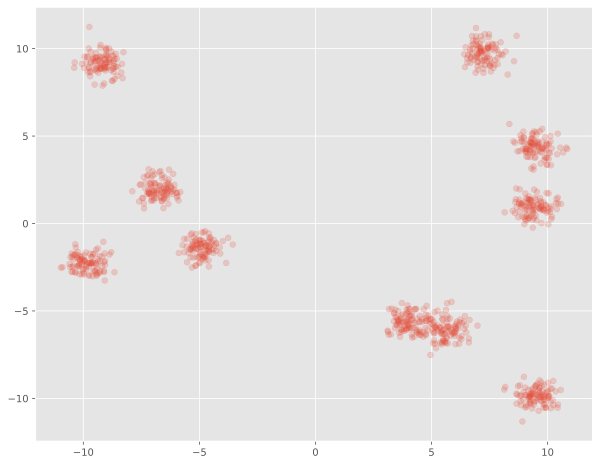

In [20]:
plt.figure(figsize = [10,8])
plt.scatter(X_blobs[:,0], X_blobs[:,1], alpha = 0.2)

In [21]:
# Pre-defined Class predictions - For 3 Clusters
class_predictions = np.load('sample_clusters.npy') # in order of X_blob cluster formed. Its in sync with that

In [22]:
import random
cp = class_predictions.copy() # trying different combination 
random.shuffle(cp)

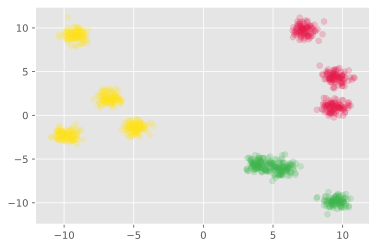

In [23]:
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters: 
    X = X_blobs[class_predictions == unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha = 0.2, c = cols[unique_cluster])

In [24]:
silhouette_score(X_blobs, class_predictions)

0.6657220862867241

In [25]:
# Pre-defined Class predictions - For 10 Clusters
class_predictions = np.load('sample_clusters_improved.npy')

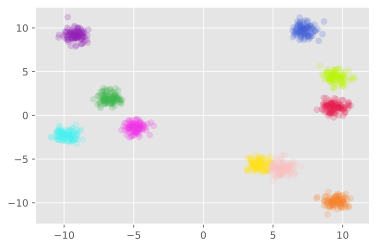

In [26]:
clusters = np.unique(class_predictions)
for cluster in clusters:
    X = X_blobs[class_predictions == cluster]
    plt.scatter(X[:,0], X[:,1], alpha = 0.2, c = cols[cluster])

In [27]:
silhouette_score(X_blobs, class_predictions)

0.7473587799908298

<a id='task4'></a>
# Task 4: K-Means Clustering

In [28]:
# Defining feature matrix
X = df[['LAT','LON']]
# Assigning intial Clusters randomly (desired number of taxi service centres.)
k = 70
model = KMeans(n_clusters = k, random_state = 17).fit(X)
class_predictions = model.predict(X)

df[f'CLUSTER_kmeans{k}'] = class_predictions

In [29]:
df.head()

LON       LAT                          NAME  CLUSTER_kmeans70
0  28.17858 -25.73882         11th Street Taxi Rank                15
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank                15
2  27.83239 -26.53722          Adams Road Taxi Rank                 5
3  28.12514 -26.26666  Alberton City Mall Taxi Rank                33
4  28.10144 -26.10567      Alexandra Main Taxi Rank                18

In [30]:
# Assigning clusters to the taxi ranks on the map

def create_map(df, cluster_column): 
    '''
    create_map takes in the dataframe and the column with the desired cluster numbers.
    It assigns different colors to each clustered point and plots it on the map. 
    Note: the number of clusters are more than the number of colors we have defined above.
    So the colors will be repeated. However if we hover over any taxi rank, the cluster label will pop-up.
    '''
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')
    for _, row in df.iterrows():
        
        if row[cluster_column] == -1: # -1 is for the singleton cases while using DBSCAN and HDBSCAN
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location= [row['LAT'], row['LON']],
            radius=5,
            popup= row[cluster_column],
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)
    return m

                   
m = create_map(df,'CLUSTER_kmeans70')
    
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

# saving to an permanent html file
m.save('kmeans_70.html')

K=70
Silhouette Score: 0.6367300949827175


In [31]:
m

In [32]:
# Checking for optimum number of clusters, by assessing it against Silhouette scores.

best_silhouette, best_k = -1, 0

for k in tqdm(range(50, 120)):
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
        
print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}') 

100%|██████████| 70/70 [00:47<00:00,  1.48it/s]

K=108
Silhouette Score: 0.7271080543664341


In [33]:
df['CLUSTER_kmeans108'] = class_predictions
df.head()

LON       LAT                          NAME  CLUSTER_kmeans70  \
0  28.17858 -25.73882         11th Street Taxi Rank                15   
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank                15   
2  27.83239 -26.53722          Adams Road Taxi Rank                 5   
3  28.12514 -26.26666  Alberton City Mall Taxi Rank                33   
4  28.10144 -26.10567      Alexandra Main Taxi Rank                18   

   CLUSTER_kmeans108  
0                 13  
1                 13  
2                 83  
3                 64  
4                 40

<a id='task5'></a>
# Task 5: DBSCAN 
Density-Based Spatial Clustering of Applications with Noise

In [34]:
# code for indexing out certain values

# -1 denotes noise
dummy = np.array([-1, -1, -1, 2, 3, 4, 5, -1])

In [35]:
# comprehension for transforming each -1s into a unique number (it doesn't need to be -ve, but its easier that way
# since the numbers wont mix up with the cluster number.) 

numbers = [(x*counter - 2) if x == -1 else x for counter, x in enumerate(dummy)]

In [36]:
model = DBSCAN(eps = 0.01, min_samples = 5).fit(X)
class_predictions = model.labels_
df['CLUSTER_DBSCAN'] = class_predictions

In [37]:
m = create_map(df,'CLUSTER_DBSCAN')
    
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

#m.save('kmeans_70.html')

K=119
Silhouette Score: 0.2992028904776304


In [38]:
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 51
Number of outliers found: 289
Silhouette ignoring outliers: 0.9232138256614868
Silhouette outliers as singletons: 0.5667489355530314


In [39]:
m # all black taxi ranks represent singletons (-1)

<a id='task6'></a>
# Task 6: HDBSCAN
Hierarchical DBSCAN

In [40]:
model = hdbscan.HDBSCAN(min_cluster_size = 5, min_samples=2, cluster_selection_epsilon=0.01)
class_predictions = model.fit_predict(X)
df['CLUSTER_HDBSCAN'] = class_predictions

In [41]:
m = create_map(df, 'CLUSTER_HDBSCAN')

print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

m

Number of clusters found: 66
Number of outliers found: 102
Silhouette ignoring outliers: 0.767050436112213
Silhouette outliers as singletons: 0.638992483653762


<a id='task7'></a>
# Task 7: Addressing Outliers


To adress Outliers we will implement a hybrid model. 

We cant have one service Centre for each Singelton. That would be too expensive. 

The idea here is to assign all the singeltons to their neighbouring clusters. This approach only makes sense given the problem at hand. It would make sense for the Taxi service Centre of the closest cluster to go and service the Singelton taxi rank. 

To do this we will use supervised learning. 
1. We will train a supervised learning model on the all the non-singelton clusters - with Lat and Lon as featues and cluster number at target variable
2. We will then let the model predict cluster numbers for the singeltons. 

The model we will be using is K Nearest Neighbors.

In [42]:
classifier = KNeighborsClassifier(n_neighbors = 2)

In [43]:
# Dividing into train and test set
df_train = df[df.CLUSTER_HDBSCAN != -1]
df_test = df[df.CLUSTER_HDBSCAN == -1]

In [44]:
# Dividing into features and target variables
X_train = df_train[['LON','LAT']]
y_train = df_train['CLUSTER_HDBSCAN']

X_test = df_test[['LON','LAT']]

In [45]:
# training the model
classifier.fit(X_train, y_train)
# Model predicitions
y_pred = classifier.predict(X_test)

In [46]:
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN']

In [47]:
# Replacing -1s with predicted cluster numbers. We didn't shuffle the data so the assignment is already ordered. 
df.loc[df['CLUSTER_hybrid'] == -1, 'CLUSTER_hybrid'] = y_pred

In [48]:
m = create_map(df, 'CLUSTER_hybrid')

In [49]:
m

In [50]:
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

m.save('hybrid.html')

Number of clusters found: 67
Silhouette: 0.5686171945317242


In [51]:
df.head()

LON       LAT                          NAME  CLUSTER_kmeans70  \
0  28.17858 -25.73882         11th Street Taxi Rank                15   
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank                15   
2  27.83239 -26.53722          Adams Road Taxi Rank                 5   
3  28.12514 -26.26666  Alberton City Mall Taxi Rank                33   
4  28.10144 -26.10567      Alexandra Main Taxi Rank                18   

   CLUSTER_kmeans108  CLUSTER_DBSCAN  CLUSTER_HDBSCAN  CLUSTER_hybrid  
0                 13               0               19              19  
1                 13               0               19              19  
2                 83              -1               -1              26  
3                 64              -1               -1              41  
4                 40               1               55              55

Text(0.5, 1.0, 'Comparision between Hybrid and K-Means Clustering')

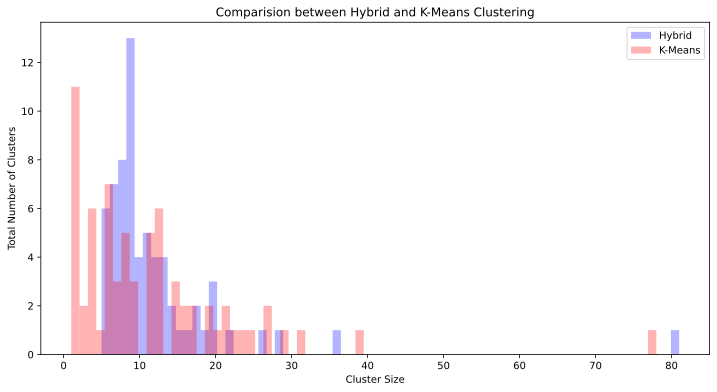

In [52]:
# Comparing Cluster Sizes spread between Hybrid and KMeans Clustering

plt.style.use('default')
plt.figure(figsize = (12,6))

df['CLUSTER_hybrid'].value_counts().sort_values(ascending = True).plot(kind = 'hist',bins = 70, alpha = 0.3,
                                                                       color = 'b', label = 'Hybrid')
df['CLUSTER_kmeans70'].value_counts().sort_values(ascending = True).plot(kind = 'hist',bins = 70, alpha = 0.3,
                                                                         color = 'r', label = 'K-Means')
#df['CLUSTER_hybrid'].value_counts().sort_values(ascending = True).plot(kind = 'barh', alpha = 0.5, color = 'b')


plt.legend()
plt.xlabel('Cluster Size')
plt.ylabel('Total Number of Clusters')
plt.title('Comparision between Hybrid and K-Means Clustering')

# Conclusion

Even though the Silhouette score of the Hybrid Clustering is lower than that of K-Means, its still the better model given the domain and problem at hand. 

It can be justified by observing the Comparision plot above. 
- With K-Means there are lots of clusters of size less than 5. This is not feasible economically, as it will be expensive to operate service stations for very few taxi ranks. 
- On the other hand, Hybrid Clustering forms clusters with atleast 5 taxi ranks, and assigns the singeltons to the nearest cluster instead of making them independent clusters. 


<a id='further'></a>
# Further Reading

For some additional reading, feel free to check out [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), and [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/) clustering respectively.

It may be of use to also check out [other forms of clustering](https://scikit-learn.org/stable/modules/clustering.html) that are commonly used and available in the scikit-learn library. HDBSCAN documentation also includes [a good methodology](https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html) for choosing your clustering algorithm based on your dataset and other limiting factors.